<a href="https://colab.research.google.com/github/PoojithRangineni/Stock-Analysis-with-Traditional-Machine-Learning-and-Deep-Learning-Models/blob/main/StockPrediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

StockAnalyzer initialized for AAPL
Starting full analysis for AAPL...
Data fetched successfully for AAPL
Data prepared with shape: X_train: (5053, 20, 10), y_train: (5053,)
Building traditional models...
Traditional models built successfully
Building RNN-LSTM model...
RNN-LSTM model built successfully
Building CNN-LSTM model...
CNN-LSTM model built successfully
Building hybrid LSTM model...
Hybrid LSTM model built successfully
Training traditional models...
Training linear...
linear trained. MSE: 0.000265, MAE: 0.004536, R²: 0.969945
Training decision_tree...
decision_tree trained. MSE: 0.000281, MAE: 0.007189, R²: 0.968091
Training random_forest...
random_forest trained. MSE: 0.000266, MAE: 0.004836, R²: 0.969886
Training svr...
svr trained. MSE: 0.002018, MAE: 0.038049, R²: 0.771129
Training knn...
knn trained. MSE: 0.001603, MAE: 0.019397, R²: 0.818168
All traditional models trained successfully
Training neural network models...
Training rnn_lstm...
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14m

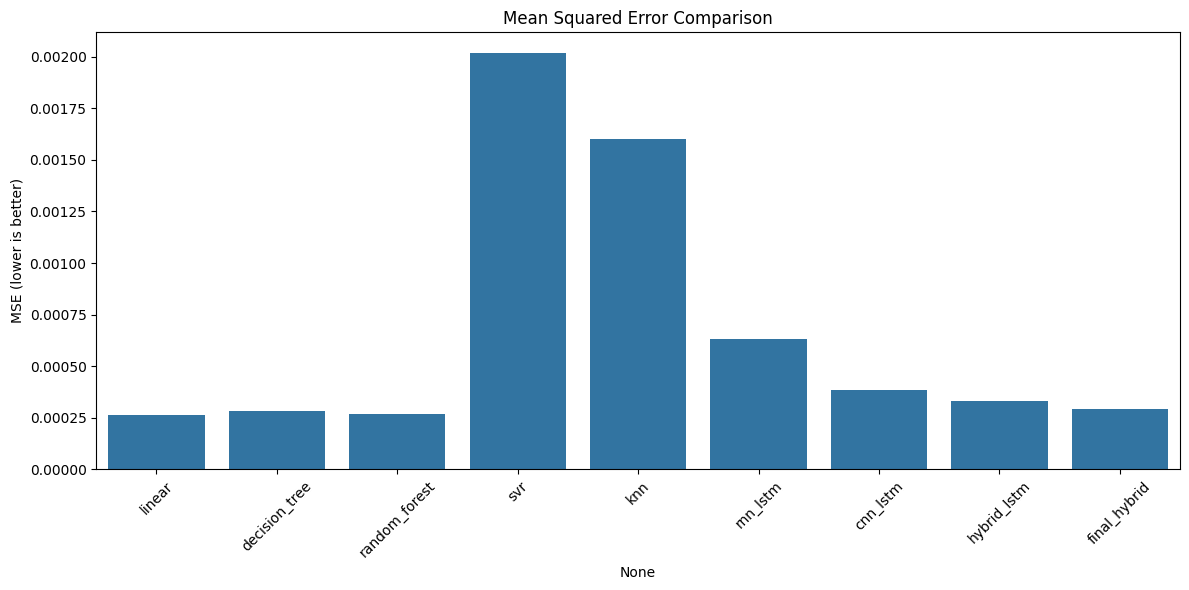

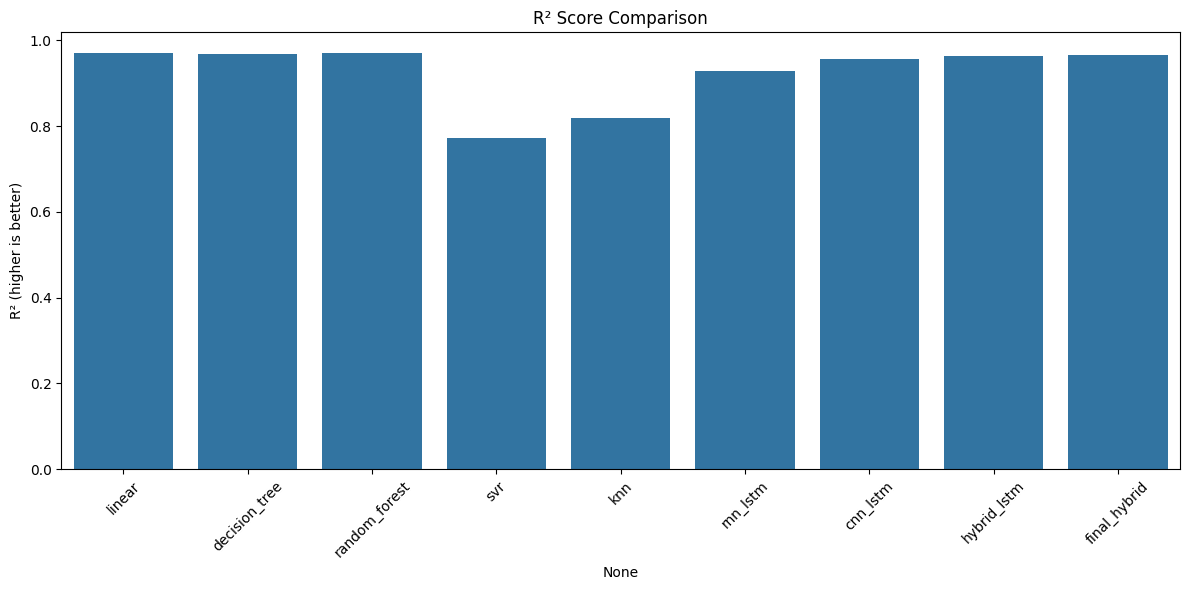

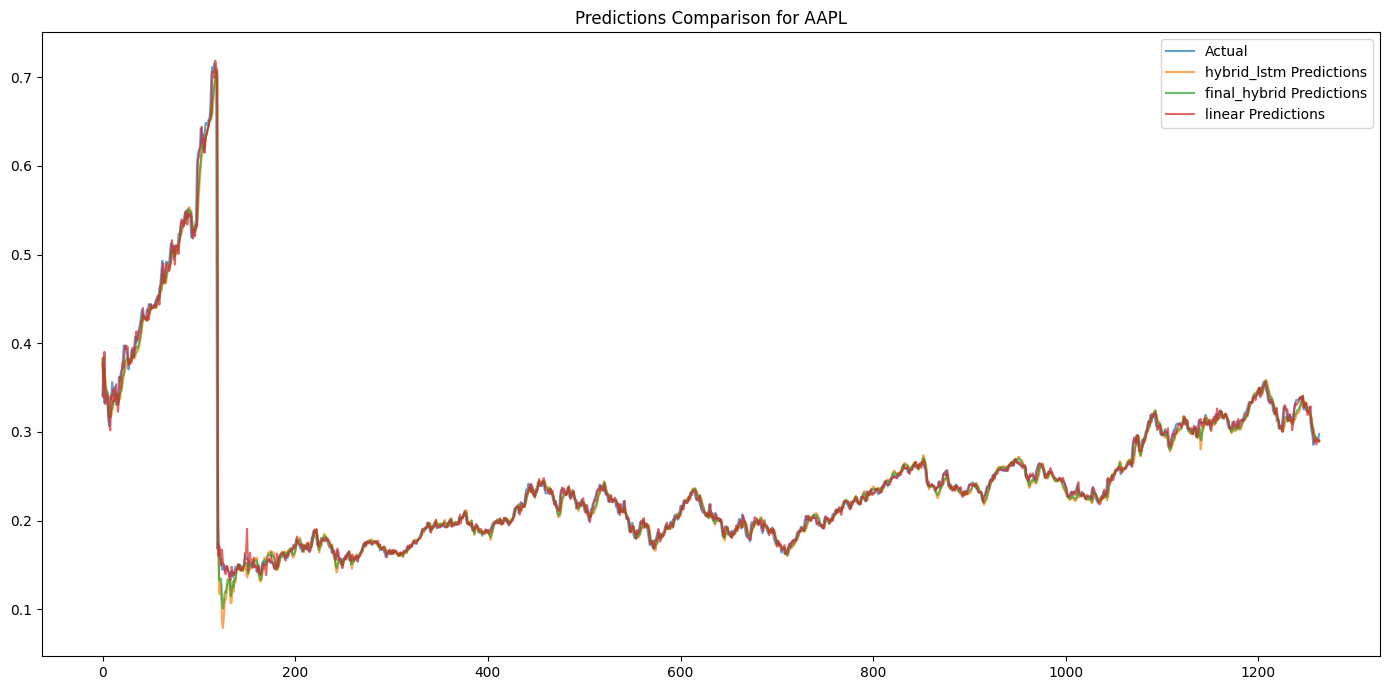

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

class StockAnalyzer:
    def __init__(self, symbol, api_key, output_size='full'):
        """
        Initialize the StockAnalyzer with stock symbol and API key.

        Parameters:
        -----------
        symbol : str
            The stock symbol to analyze
        api_key : str
            Alpha Vantage API key
        output_size : str
            'compact' or 'full' data from Alpha Vantage
        """
        self.symbol = symbol
        self.api_key = api_key
        self.output_size = output_size
        self.data = None
        self.models = {}
        self.results = {}
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        print(f"StockAnalyzer initialized for {symbol}")

    def fetch_data(self):
        """
        Fetch stock data from Alpha Vantage API
        """
        try:
            base_url = 'https://www.alphavantage.co/query'
            params = {
                'function': 'TIME_SERIES_DAILY',
                'symbol': self.symbol,
                'outputsize': self.output_size,
                'apikey': self.api_key
            }

            response = requests.get(base_url, params=params)
            data = response.json()

            if "Error Message" in data:
                print(f"Error: {data['Error Message']}")
                return False

            time_series = data.get('Time Series (Daily)', {})

            if not time_series:
                print("No data found or API limit reached")
                return False

            # Convert to DataFrame
            df = pd.DataFrame(time_series).T

            # Rename columns and convert to float
            df.columns = ['open', 'high', 'low', 'close', 'volume']
            for col in df.columns:
                df[col] = df[col].astype(float)

            # Add date as a column and sort by date
            df.index = pd.to_datetime(df.index)
            df = df.sort_index()

            # Calculate additional features
            df['returns'] = df['close'].pct_change()
            df['log_returns'] = np.log(df['close']/df['close'].shift(1))
            df['ma_5'] = df['close'].rolling(window=5).mean()
            df['ma_20'] = df['close'].rolling(window=20).mean()
            df['ma_50'] = df['close'].rolling(window=50).mean()
            df['std_5'] = df['close'].rolling(window=5).std()
            df['upper_band'] = df['ma_20'] + (df['std_5'] * 2)
            df['lower_band'] = df['ma_20'] - (df['std_5'] * 2)
            df['rsi_14'] = self._calculate_rsi(df['close'], 14)

            # Drop NaN values
            df = df.dropna()

            self.data = df
            print(f"Data fetched successfully for {self.symbol}")
            return True

        except Exception as e:
            print(f"Error fetching data: {e}")
            return False

    def _calculate_rsi(self, prices, window=14):
        """Calculate RSI indicator"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def prepare_data(self, target_col='close', sequence_length=10, test_size=0.2):
        """
        Prepare data for training and testing models

        Parameters:
        -----------
        target_col : str
            Column to predict
        sequence_length : int
            Number of previous days to use for prediction
        test_size : float
            Proportion of data to use for testing
        """
        if self.data is None:
            print("No data available. Please fetch data first.")
            return False

        # Select features and target
        feature_cols = ['open', 'high', 'low', 'close', 'volume',
                      'returns', 'ma_5', 'ma_20', 'ma_50', 'rsi_14']

        # Scale the features
        data_scaled = self.scaler.fit_transform(self.data[feature_cols])

        # Create sequences for LSTM models
        X, y = [], []
        for i in range(len(data_scaled) - sequence_length):
            X.append(data_scaled[i:i+sequence_length])
            # Target is the next day's closing price
            y.append(data_scaled[i+sequence_length, feature_cols.index(target_col)])

        X, y = np.array(X), np.array(y)

        # Split into train and test sets
        split_idx = int(len(X) * (1 - test_size))
        self.X_train, self.X_test = X[:split_idx], X[split_idx:]
        self.y_train, self.y_test = y[:split_idx], y[split_idx:]

        # For traditional models, flatten the sequences
        self.X_train_2D = self.X_train.reshape(self.X_train.shape[0], -1)
        self.X_test_2D = self.X_test.reshape(self.X_test.shape[0], -1)

        print(f"Data prepared with shape: X_train: {self.X_train.shape}, y_train: {self.y_train.shape}")
        self.sequence_length = sequence_length
        self.n_features = len(feature_cols)
        self.target_col = target_col
        self.feature_cols = feature_cols

        return True

    def build_traditional_models(self):
        """Build 5 traditional prediction models"""
        print("Building traditional models...")

        # Linear Regression
        self.models['linear'] = LinearRegression()

        # Decision Tree
        self.models['decision_tree'] = DecisionTreeRegressor(random_state=42)

        # Random Forest
        self.models['random_forest'] = RandomForestRegressor(n_estimators=100, random_state=42)

        # SVR
        self.models['svr'] = SVR(kernel='rbf')

        # KNN
        self.models['knn'] = KNeighborsRegressor(n_neighbors=5)

        print("Traditional models built successfully")

    def build_rnn_lstm(self):
        """Build a simple RNN-LSTM model"""
        print("Building RNN-LSTM model...")

        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(self.sequence_length, self.n_features)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        self.models['rnn_lstm'] = model

        print("RNN-LSTM model built successfully")

    def build_cnn_lstm(self):
        """Build a CNN-LSTM model"""
        print("Building CNN-LSTM model...")

        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                         input_shape=(self.sequence_length, self.n_features)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(units=50, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        self.models['cnn_lstm'] = model

        print("CNN-LSTM model built successfully")

    def build_hybrid_lstm_model(self):
        """Build a hybrid model combining RNN-LSTM and CNN-LSTM"""
        print("Building hybrid LSTM model...")

        # Input layer
        input_layer = Input(shape=(self.sequence_length, self.n_features))

        # RNN-LSTM branch
        lstm1 = LSTM(units=50, return_sequences=True)(input_layer)
        lstm1 = Dropout(0.2)(lstm1)
        lstm1 = LSTM(units=50)(lstm1)
        lstm1 = Dropout(0.2)(lstm1)

        # CNN-LSTM branch
        conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
        conv1 = MaxPooling1D(pool_size=2)(conv1)
        lstm2 = LSTM(units=50, return_sequences=True)(conv1)
        lstm2 = Dropout(0.2)(lstm2)
        lstm2 = LSTM(units=50)(lstm2)
        lstm2 = Dropout(0.2)(lstm2)

        # Merge branches
        merged = Concatenate()([lstm1, lstm2])

        # Output layer
        output = Dense(units=1)(merged)

        # Create and compile model
        model = Model(inputs=input_layer, outputs=output)
        model.compile(optimizer='adam', loss='mean_squared_error')

        self.models['hybrid_lstm'] = model

        print("Hybrid LSTM model built successfully")

    def build_final_hybrid_model(self, best_traditional_model):
        """
        Build a hybrid model combining the best traditional model with the hybrid LSTM model

        Parameters:
        -----------
        best_traditional_model : str
            Name of the best performing traditional model
        """
        print(f"Building final hybrid model with {best_traditional_model}...")

        # For this implementation, we'll use feature importances from the best traditional model
        # to enhance the hybrid LSTM model (only if the best model is random forest or decision tree)

        # To keep it simpler for this demo, we'll create a model that takes predictions from both
        # models and creates a weighted average

        # Note: In a real-world scenario, this would be implemented differently,
        # likely with an ensemble approach or additional neural network layers

        self.best_traditional_model = best_traditional_model
        print("Final hybrid model concept prepared (weights to be determined after training)")

    def train_traditional_models(self):
        """Train all traditional models"""
        print("Training traditional models...")

        for name, model in self.models.items():
            if name in ['linear', 'decision_tree', 'random_forest', 'svr', 'knn']:
                print(f"Training {name}...")
                model.fit(self.X_train_2D, self.y_train)

                # Make predictions
                y_pred = model.predict(self.X_test_2D)

                # Calculate metrics
                mse = mean_squared_error(self.y_test, y_pred)
                mae = mean_absolute_error(self.y_test, y_pred)
                r2 = r2_score(self.y_test, y_pred)

                # Store results
                self.results[name] = {
                    'mse': mse,
                    'mae': mae,
                    'r2': r2,
                    'predictions': y_pred
                }

                print(f"{name} trained. MSE: {mse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")

        print("All traditional models trained successfully")

    def train_neural_models(self, epochs=50, batch_size=32):
        """
        Train all neural network models

        Parameters:
        -----------
        epochs : int
            Number of training epochs
        batch_size : int
            Batch size for training
        """
        print("Training neural network models...")

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        for name, model in self.models.items():
            if name in ['rnn_lstm', 'cnn_lstm', 'hybrid_lstm']:
                print(f"Training {name}...")

                # Train model
                history = model.fit(
                    self.X_train, self.y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=0
                )

                # Make predictions
                y_pred = model.predict(self.X_test)

                # Calculate metrics
                mse = mean_squared_error(self.y_test, y_pred)
                mae = mean_absolute_error(self.y_test, y_pred)
                r2 = r2_score(self.y_test, y_pred)

                # Store results
                self.results[name] = {
                    'mse': mse,
                    'mae': mae,
                    'r2': r2,
                    'predictions': y_pred.flatten(),
                    'history': history.history
                }

                print(f"{name} trained. MSE: {mse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")

        print("All neural network models trained successfully")

    def train_final_hybrid_model(self, hybrid_lstm_weight=0.7, epochs=50, batch_size=32):
        """
        Train the final hybrid model

        Parameters:
        -----------
        hybrid_lstm_weight : float
            Weight for the hybrid LSTM predictions (between 0 and 1)
        epochs : int
            Number of training epochs
        batch_size : int
            Batch size for training
        """
        print("Training final hybrid model...")

        # For this simplified implementation, we'll create a weighted average of predictions
        # from the best traditional model and the hybrid LSTM model

        # Create weighted predictions for the test set
        trad_pred = self.results[self.best_traditional_model]['predictions']
        lstm_pred = self.results['hybrid_lstm']['predictions']

        hybrid_pred = (hybrid_lstm_weight * lstm_pred) + ((1 - hybrid_lstm_weight) * trad_pred)

        # Calculate metrics
        mse = mean_squared_error(self.y_test, hybrid_pred)
        mae = mean_absolute_error(self.y_test, hybrid_pred)
        r2 = r2_score(self.y_test, hybrid_pred)

        # Store results
        self.results['final_hybrid'] = {
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'predictions': hybrid_pred,
            'weights': {
                'hybrid_lstm': hybrid_lstm_weight,
                self.best_traditional_model: 1 - hybrid_lstm_weight
            }
        }

        print(f"Final hybrid model trained. MSE: {mse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")

    def find_best_traditional_model(self):
        """Find the best performing traditional model based on MSE"""
        trad_models = ['linear', 'decision_tree', 'random_forest', 'svr', 'knn']
        best_model = min(trad_models, key=lambda x: self.results.get(x, {}).get('mse', float('inf')))
        print(f"Best traditional model: {best_model} with MSE: {self.results[best_model]['mse']:.6f}")
        return best_model

    def compare_models(self):
        """Compare all models and visualize results"""
        print("Comparing all models...")

        # Create comparison table
        metrics = ['mse', 'mae', 'r2']
        comparison = {model: [self.results[model][metric] for metric in metrics]
                     for model in self.results}

        df_comparison = pd.DataFrame(comparison, index=metrics).T
        print("\nModel Comparison:")
        print(df_comparison)

        # Plot MSE comparison
        plt.figure(figsize=(12, 6))
        sns.barplot(x=df_comparison.index, y=df_comparison['mse'])
        plt.title('Mean Squared Error Comparison')
        plt.ylabel('MSE (lower is better)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"{self.symbol}_mse_comparison.png")

        # Plot R² comparison
        plt.figure(figsize=(12, 6))
        sns.barplot(x=df_comparison.index, y=df_comparison['r2'])
        plt.title('R² Score Comparison')
        plt.ylabel('R² (higher is better)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"{self.symbol}_r2_comparison.png")

        # Plot predictions for best model and hybrid models
        plt.figure(figsize=(14, 7))
        plt.plot(self.y_test, label='Actual', alpha=0.7)

        for model in ['hybrid_lstm', 'final_hybrid', self.best_traditional_model]:
            plt.plot(self.results[model]['predictions'], label=f"{model} Predictions", alpha=0.7)

        plt.title(f'Predictions Comparison for {self.symbol}')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{self.symbol}_predictions_comparison.png")

        print("Comparison complete. Visualizations saved to files.")

        return df_comparison

    def run_full_analysis(self, sequence_length=10, test_size=0.2, epochs=50, batch_size=32):
        """
        Run the complete analysis pipeline

        Parameters:
        -----------
        sequence_length : int
            Number of previous days to use for prediction
        test_size : float
            Proportion of data to use for testing
        epochs : int
            Number of training epochs for neural models
        batch_size : int
            Batch size for training neural models
        """
        print(f"Starting full analysis for {self.symbol}...")

        # Fetch and prepare data
        if not self.fetch_data():
            return False

        if not self.prepare_data(sequence_length=sequence_length, test_size=test_size):
            return False

        # Build models
        self.build_traditional_models()
        self.build_rnn_lstm()
        self.build_cnn_lstm()
        self.build_hybrid_lstm_model()

        # Train models
        self.train_traditional_models()
        self.train_neural_models(epochs=epochs, batch_size=batch_size)

        # Find best traditional model
        best_trad = self.find_best_traditional_model()

        # Build and train final hybrid model
        self.build_final_hybrid_model(best_trad)
        self.train_final_hybrid_model(epochs=epochs, batch_size=batch_size)

        # Compare all models
        comparison = self.compare_models()

        print(f"Full analysis completed for {self.symbol}")
        return comparison

# Usage example
if __name__ == "__main__":
    # Replace with your Alpha Vantage API key
    API_KEY = "YV0BMWWP9ZPKMJG8"

    # Initialize and run analysis for a stock
    analyzer = StockAnalyzer(symbol="AAPL", api_key=API_KEY)

    # Run full analysis
    comparison = analyzer.run_full_analysis(
        sequence_length=20,  # Use 20 days of historical data
        test_size=0.2,       # Use 20% of data for testing
        epochs=100,          # Train neural models for 100 epochs
        batch_size=32        # Use batch size of 32
    )


Analyzing AAPL

StockAnalyzer initialized for AAPL
Starting full analysis for AAPL...
Data fetched successfully for AAPL
Data prepared with shape: X_train: (5053, 20, 10), y_train: (5053,)
Building traditional models...
Traditional models built successfully
Building RNN-LSTM model...
RNN-LSTM model built successfully
Building CNN-LSTM model...
CNN-LSTM model built successfully
Building hybrid LSTM model...
Hybrid LSTM model built successfully
Training traditional models...
Training linear...
linear trained. MSE: 0.000265, MAE: 0.004536, R²: 0.969945
Training decision_tree...
decision_tree trained. MSE: 0.000281, MAE: 0.007189, R²: 0.968091
Training random_forest...
random_forest trained. MSE: 0.000266, MAE: 0.004836, R²: 0.969886
Training svr...
svr trained. MSE: 0.002018, MAE: 0.038049, R²: 0.771129
Training knn...
knn trained. MSE: 0.001603, MAE: 0.019397, R²: 0.818168
All traditional models trained successfully
Training neural network models...
Training rnn_lstm...
40/40 ━━━━━━━━━━

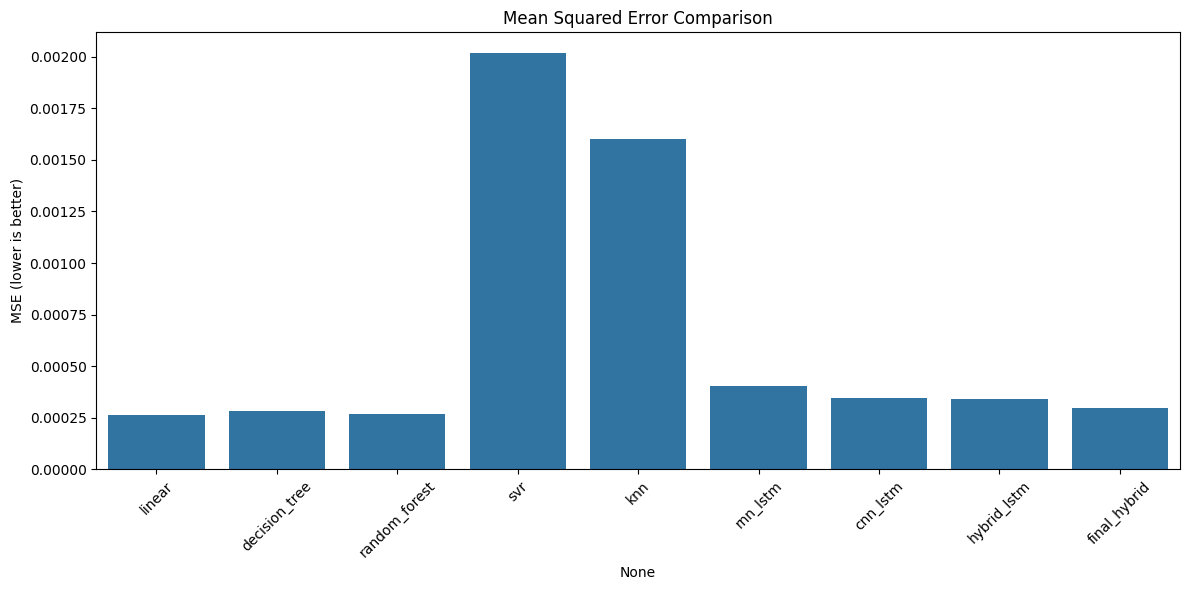

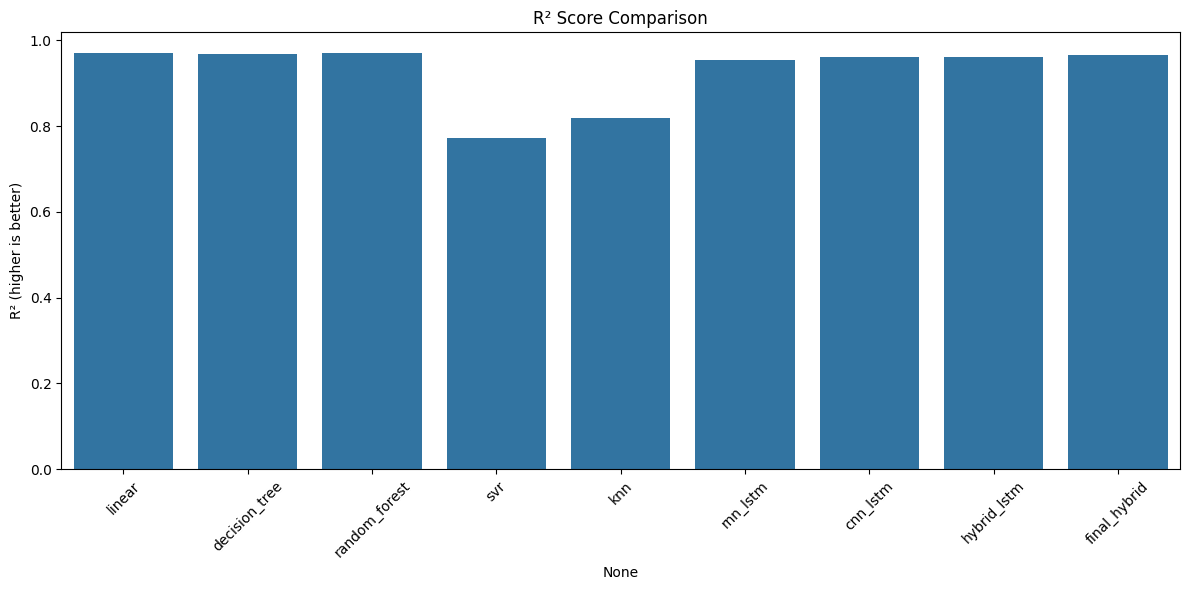

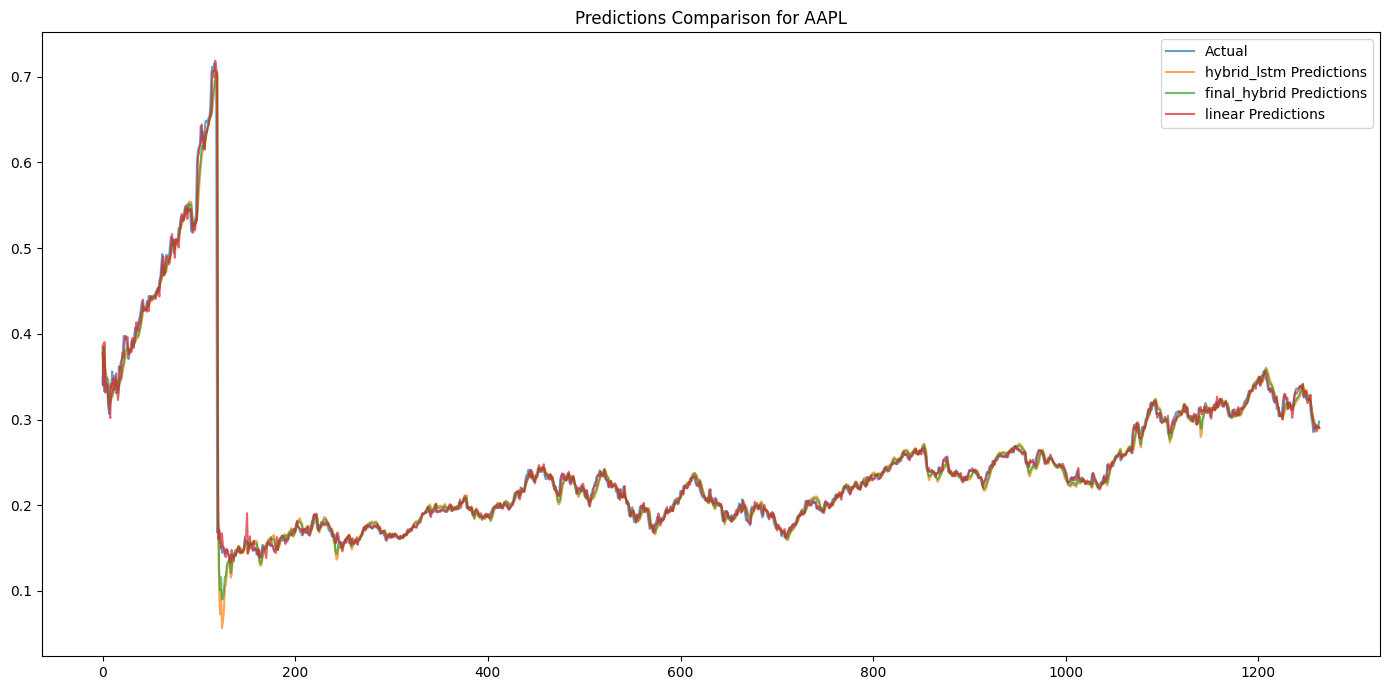

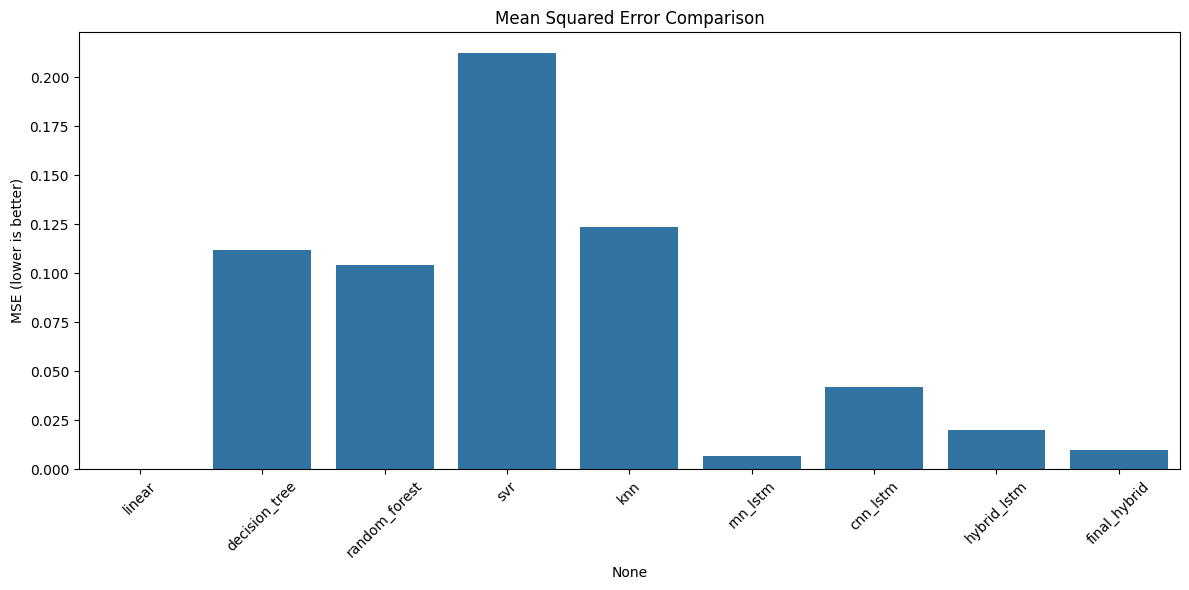

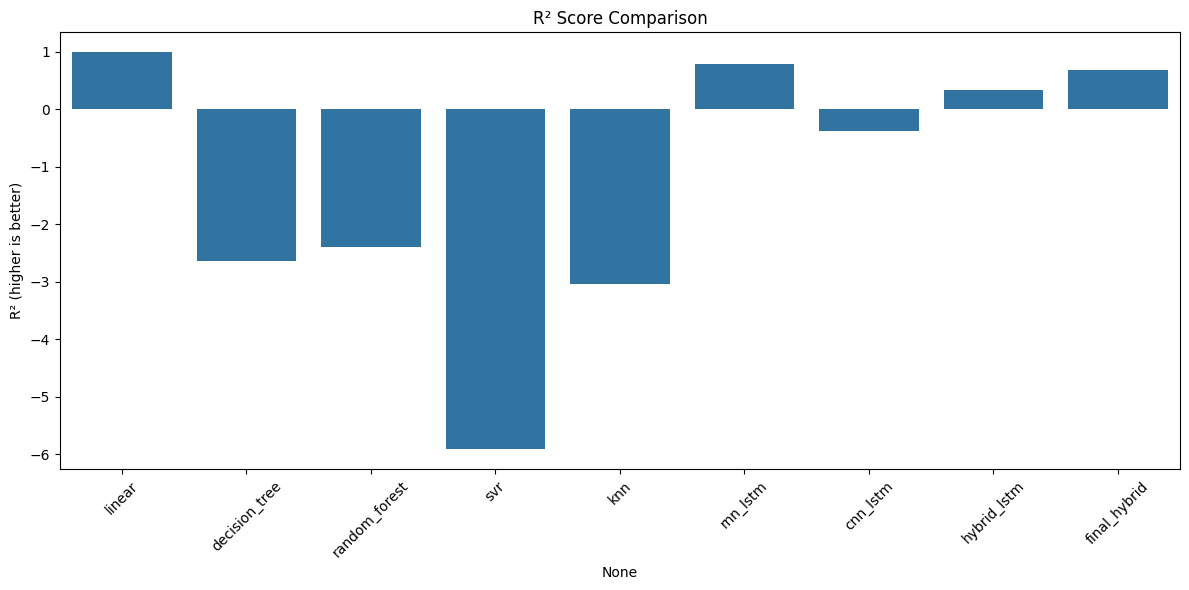

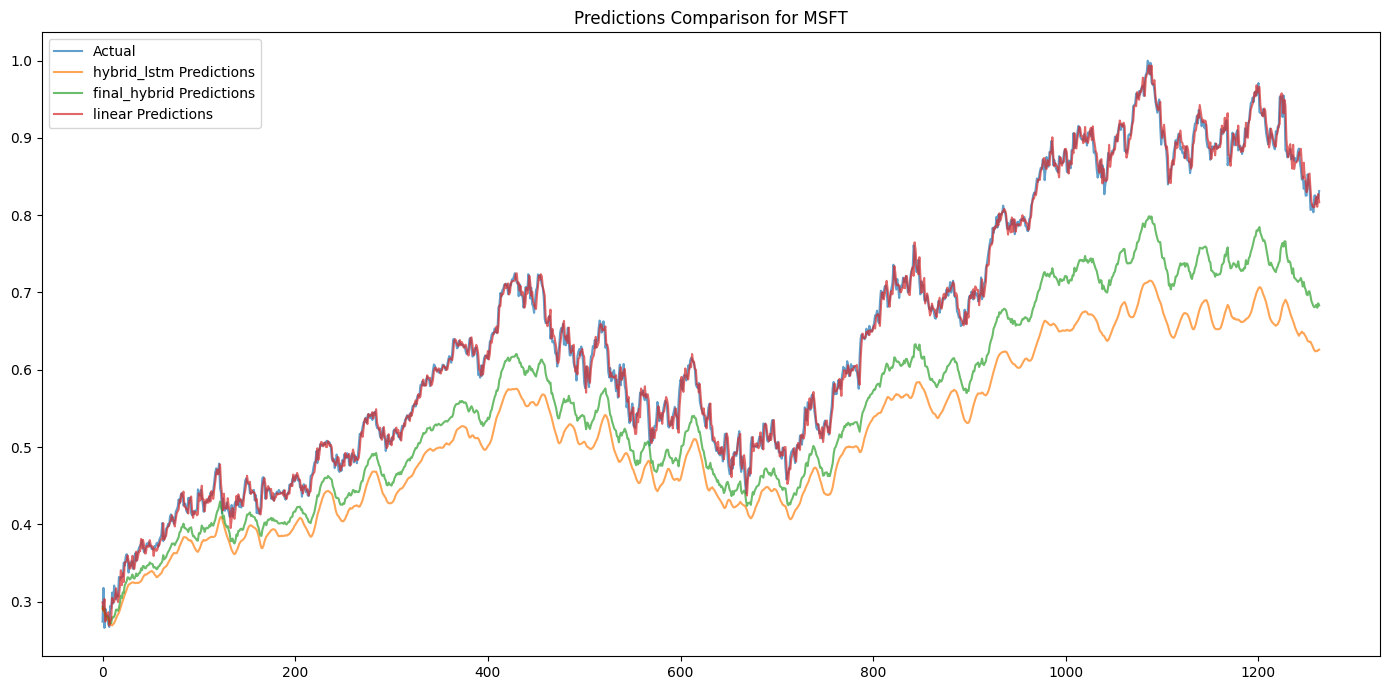

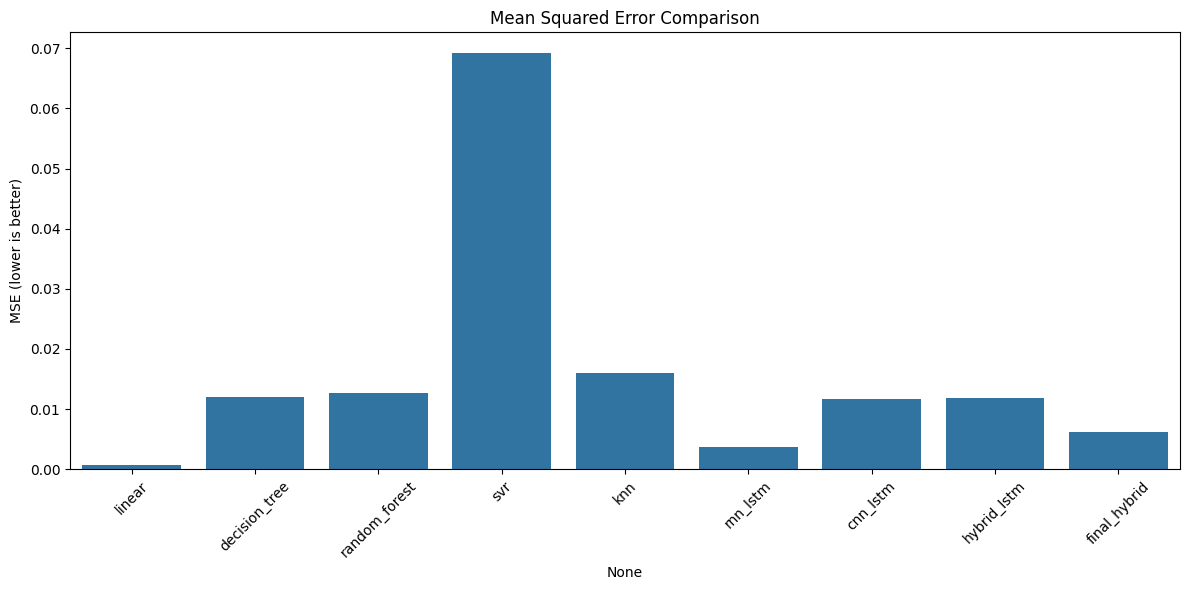

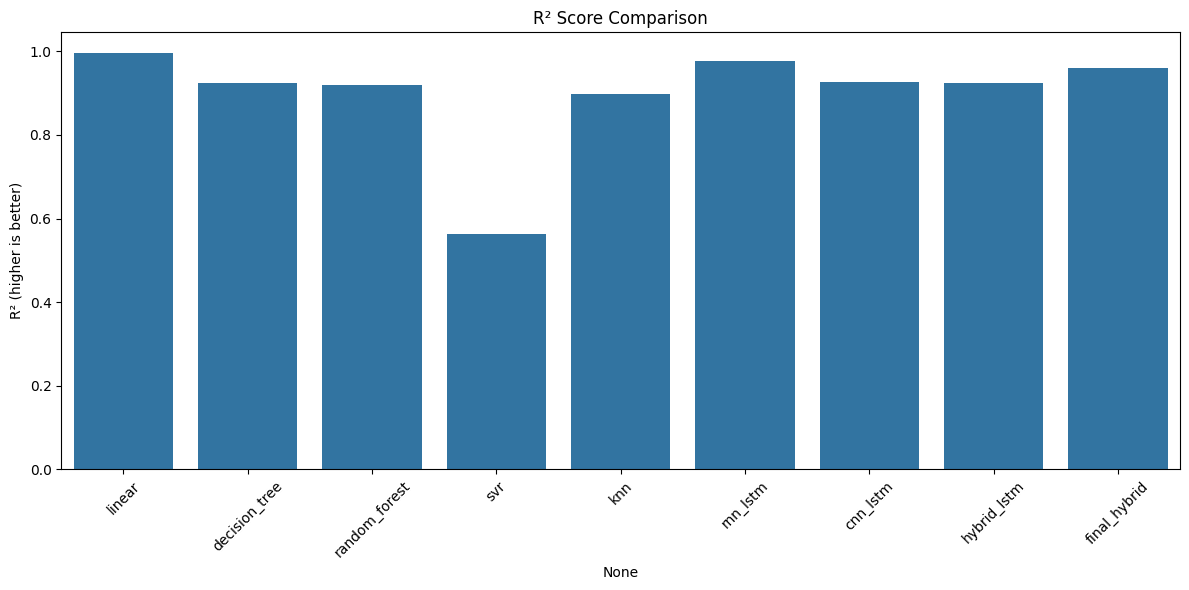

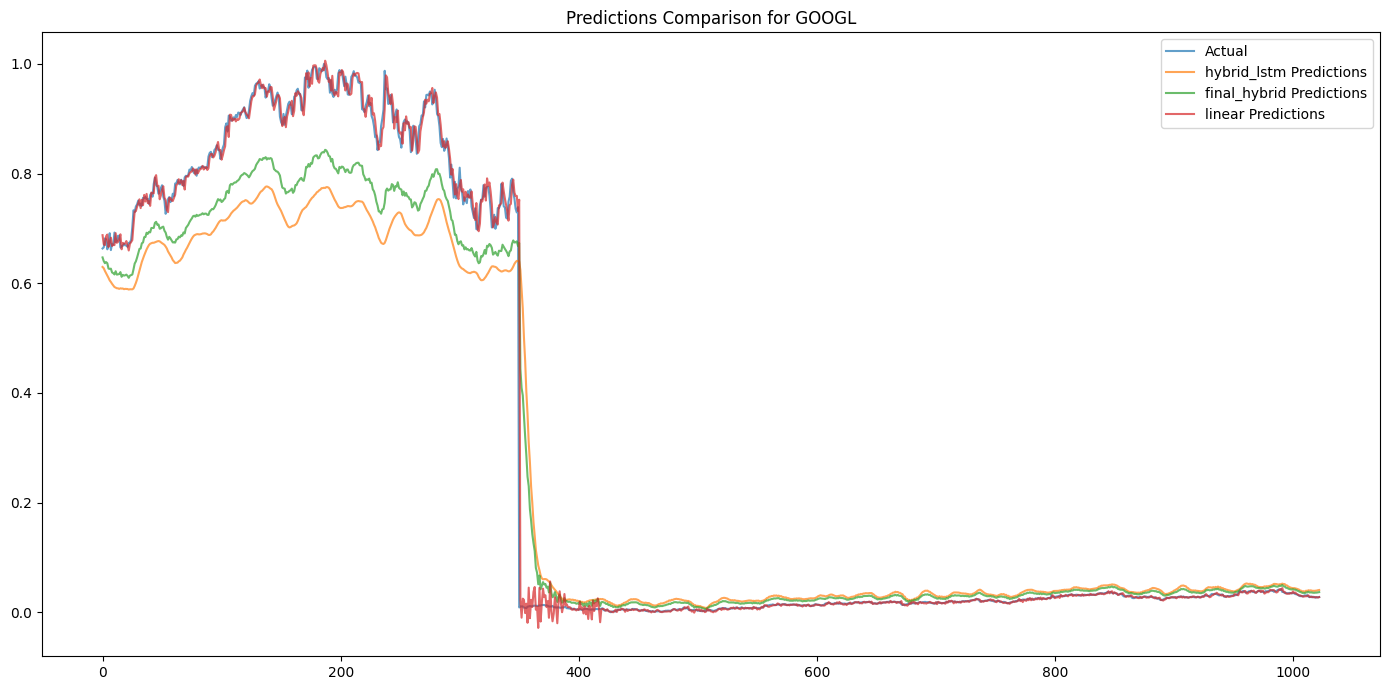

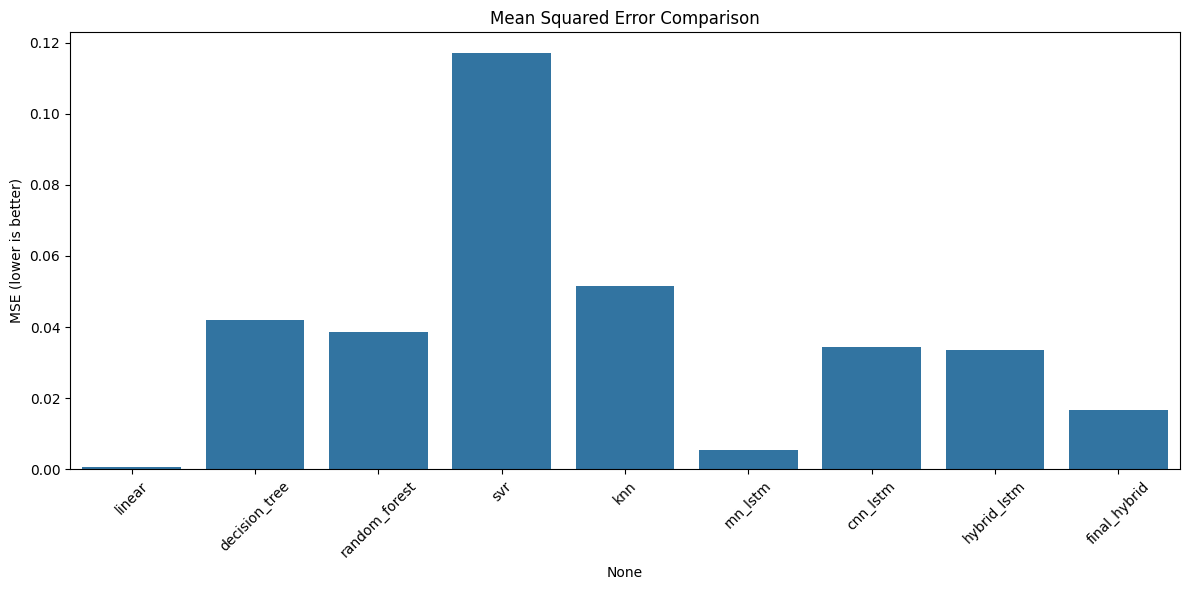

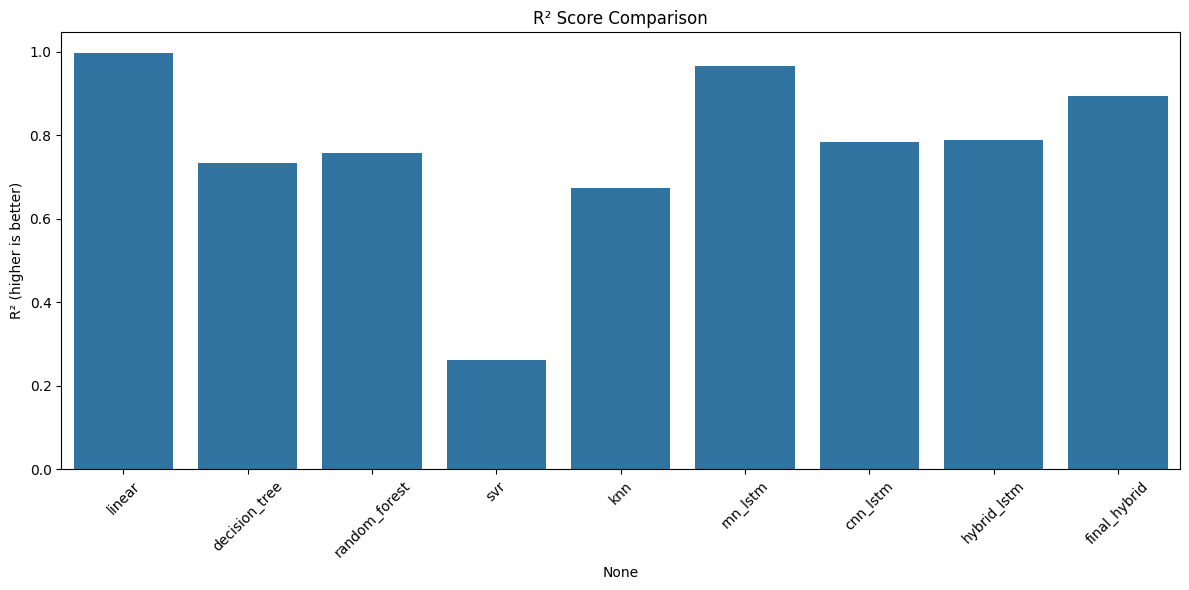

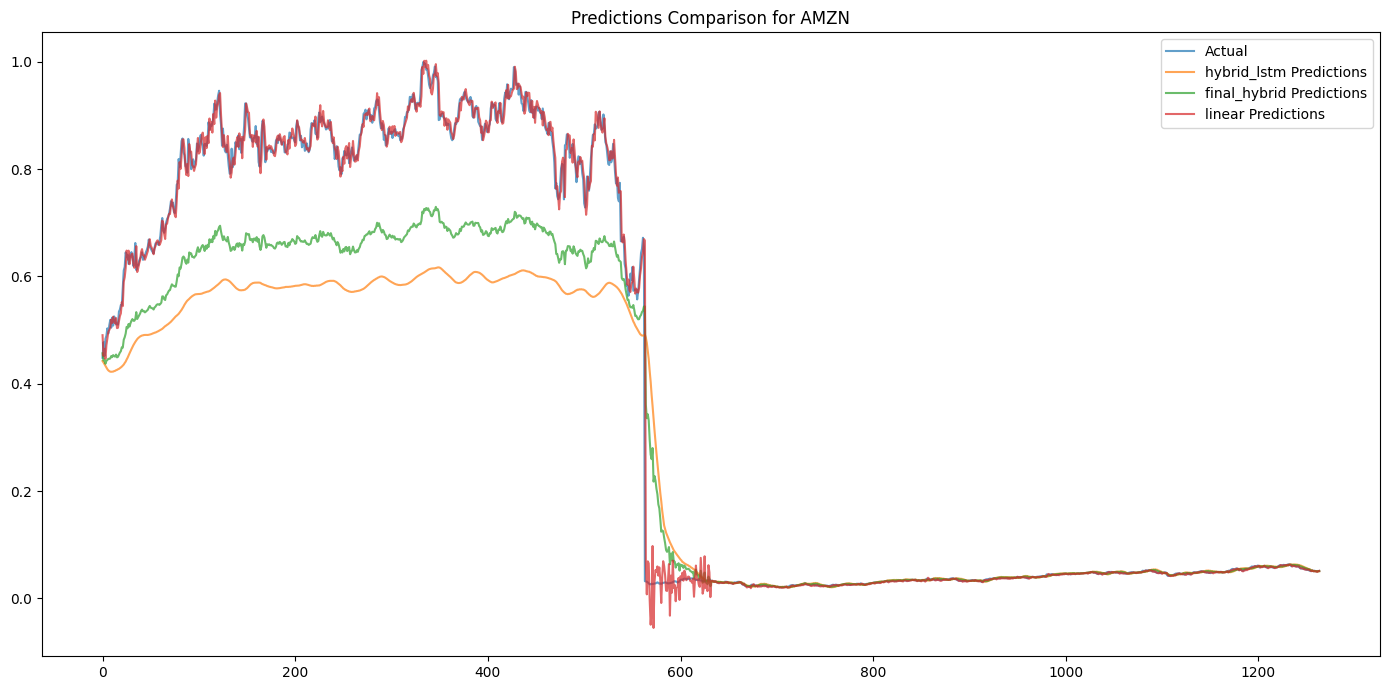

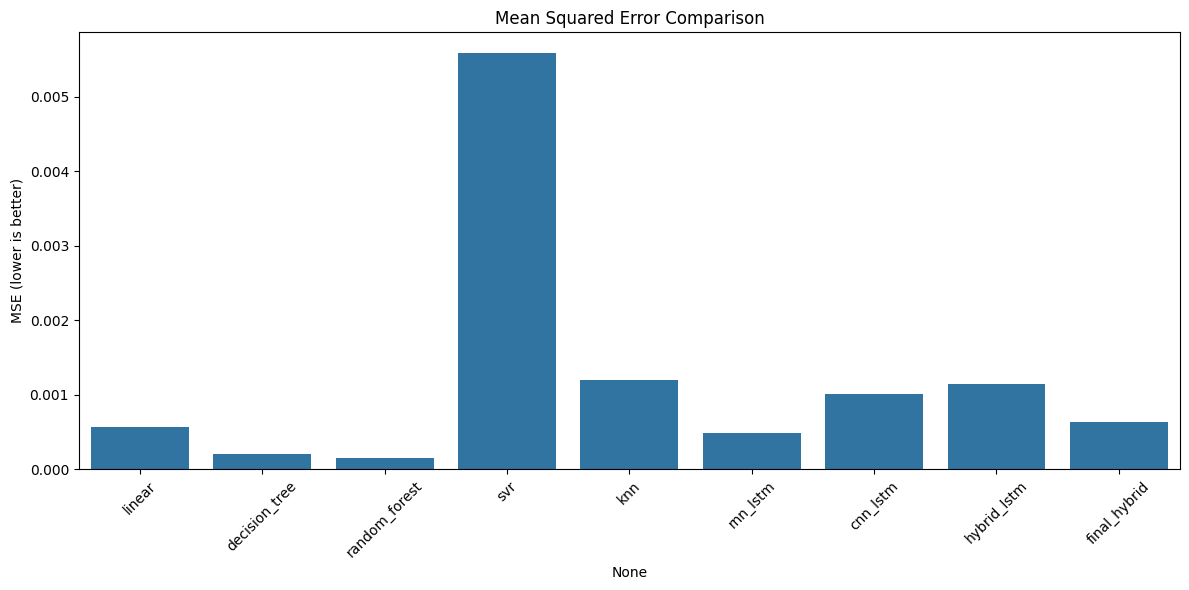

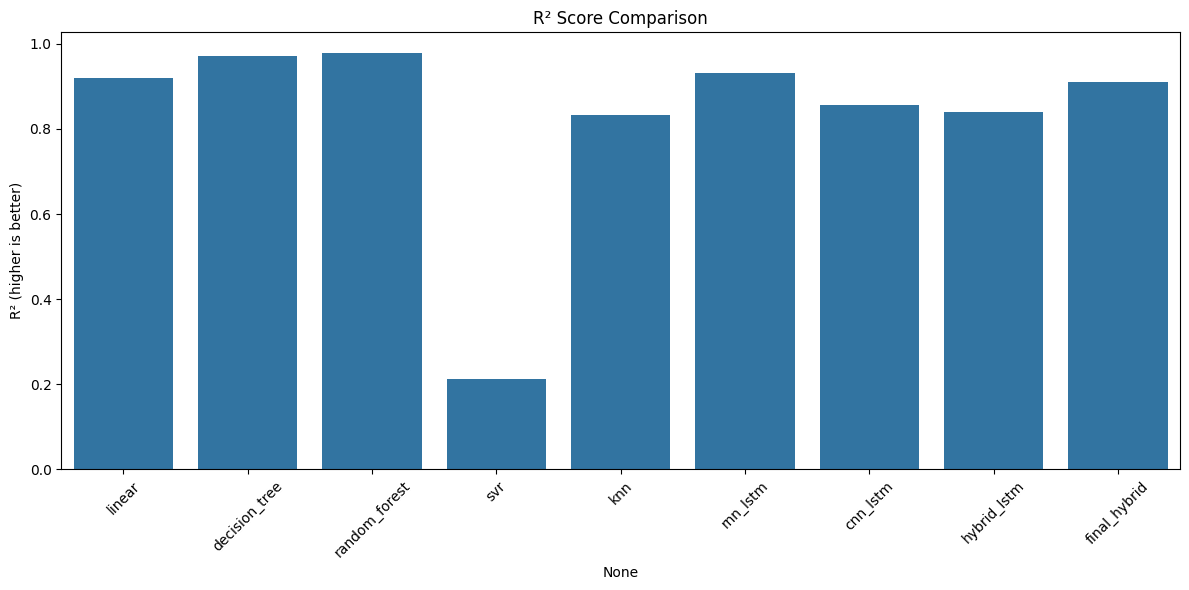

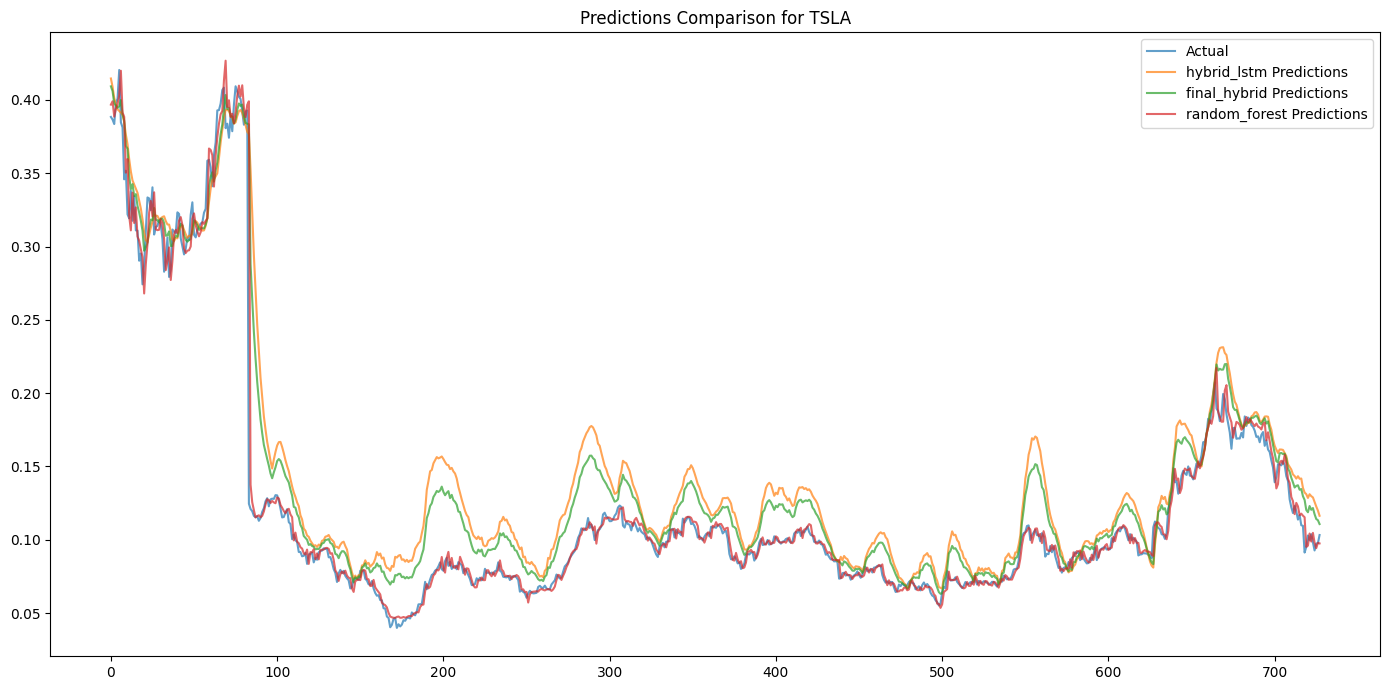

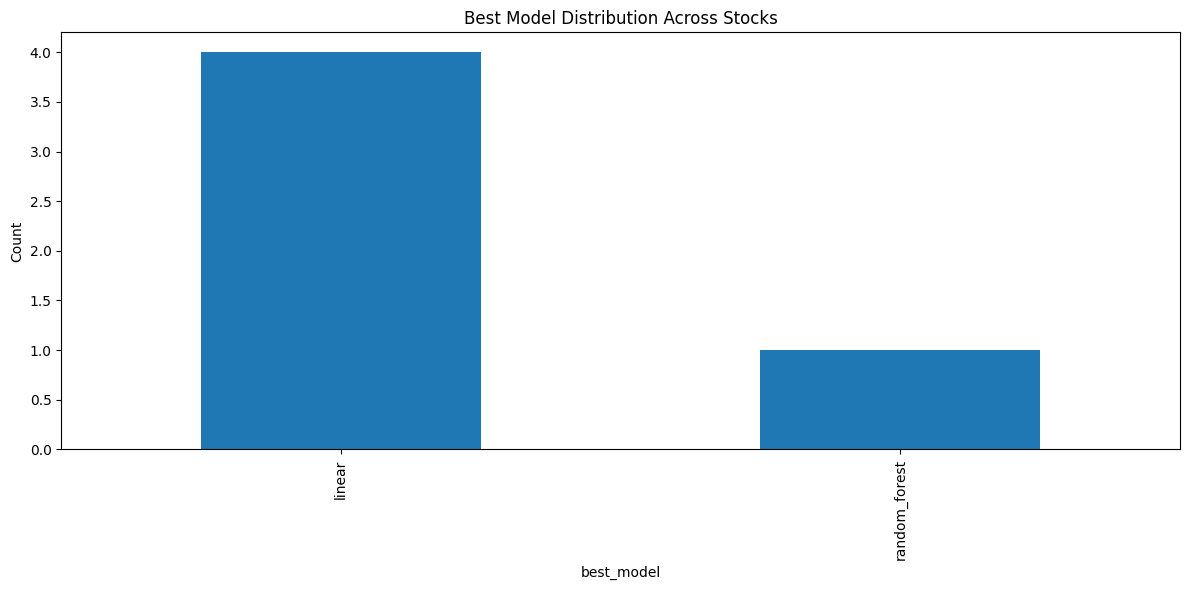

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display # Assuming the class is defined in the current notebook or a previous cell
import time

def run_multi_stock_analysis(symbols, api_key, sequence_length=20, test_size=0.2, epochs=50, batch_size=32):
    """
    Run analysis on multiple stocks and compare results

    Parameters:
    -----------
    symbols : list
        List of stock symbols to analyze
    api_key : str
        Alpha Vantage API key
    sequence_length : int
        Number of previous days to use for prediction
    test_size : float
        Proportion of data to use for testing
    epochs : int
        Number of training epochs for neural models
    batch_size : int
        Batch size for training neural models
    """
    # Store results for all stocks
    all_results = {}

    for symbol in symbols:
        print(f"\n{'='*50}")
        print(f"Analyzing {symbol}")
        print(f"{'='*50}\n")

        # Initialize analyzer
        analyzer = StockAnalyzer(symbol=symbol, api_key=api_key)

        # Run analysis
        comparison = analyzer.run_full_analysis(
            sequence_length=sequence_length,
            test_size=test_size,
            epochs=epochs,
            batch_size=batch_size
        )

        if comparison is not False:
            all_results[symbol] = {
                'comparison': comparison,
                'best_model': comparison['mse'].idxmin(),
                'best_mse': comparison['mse'].min(),
                'best_r2': comparison['r2'].max()
            }

        # Wait to avoid API rate limits
        time.sleep(15)

    # Create summary of best models for each stock
    summary = pd.DataFrame({
        'symbol': list(all_results.keys()),
        'best_model': [all_results[sym]['best_model'] for sym in all_results],
        'best_mse': [all_results[sym]['best_mse'] for sym in all_results],
        'best_r2': [all_results[sym]['best_r2'] for sym in all_results]
    })

    print("\nSummary of best models for each stock:")
    print(summary)

    # Plot summary of best models
    plt.figure(figsize=(12, 6))
    summary.set_index('symbol')['best_model'].value_counts().plot(kind='bar')
    plt.title('Best Model Distribution Across Stocks')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig("best_model_distribution.png")

    return all_results, summary

if __name__ == "__main__":
    # Replace with your Alpha Vantage API key
    API_KEY = "YOUR_ALPHA_VANTAGE_API_KEY"

    # List of stocks to analyze
    stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

    # Run analysis
    results, summary = run_multi_stock_analysis(
        symbols=stocks,
        api_key=API_KEY,
        sequence_length=20,
        test_size=0.2,
        epochs=50,
        batch_size=32
    )